# 缓存活跃近月合约数据
参考文献：天风证券金工报告：商品期货CTA专题报告（十一）  
定义“活跃近月合约”为连续三日成交额大于2000万元到期日最早的合约。  
切换规则为：日成交金额连续三日低于2000万或到期期限不足30日。

In [1]:
import sys
sys.path.append('C:\\Users\\xpy\\work\\strategies2py\\AprilQuant')

import re
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse

from cache.utils import get_commodity_category
from make_daily_active_near_cache import (
    to_datetime,
    is_active,
    is_inactive,
    select_active_near_contract
)
    
warnings.filterwarnings('ignore')

## 问题：经常无法选到符合要求的合约的品种
作图：有可选择的近月合约时为1，无符合要求的合约时为0

In [2]:
data = pd.read_csv('../data/daily/commodityall_daily.csv', parse_dates=['datetime'])
data = data[data.datetime > parse('2010-01-01')]
data['category'] = data['code'].apply(get_commodity_category)

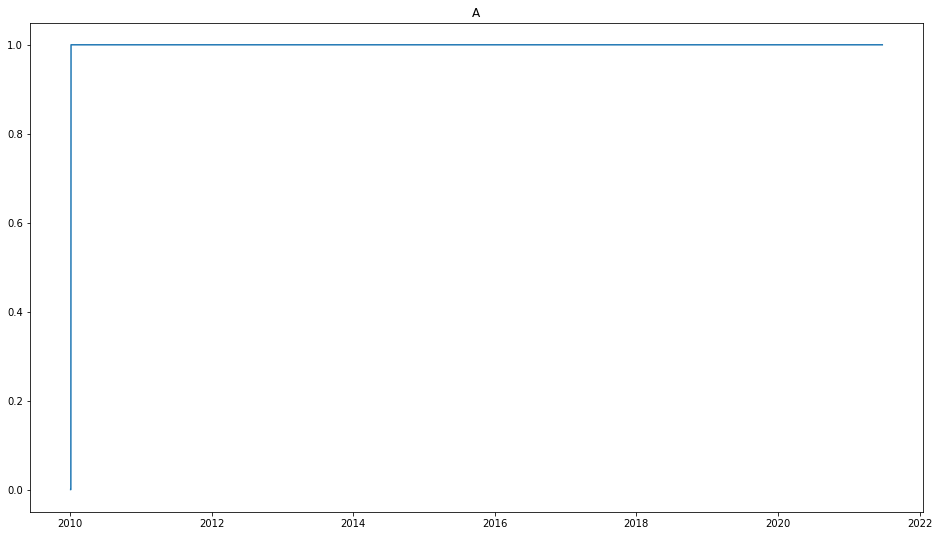

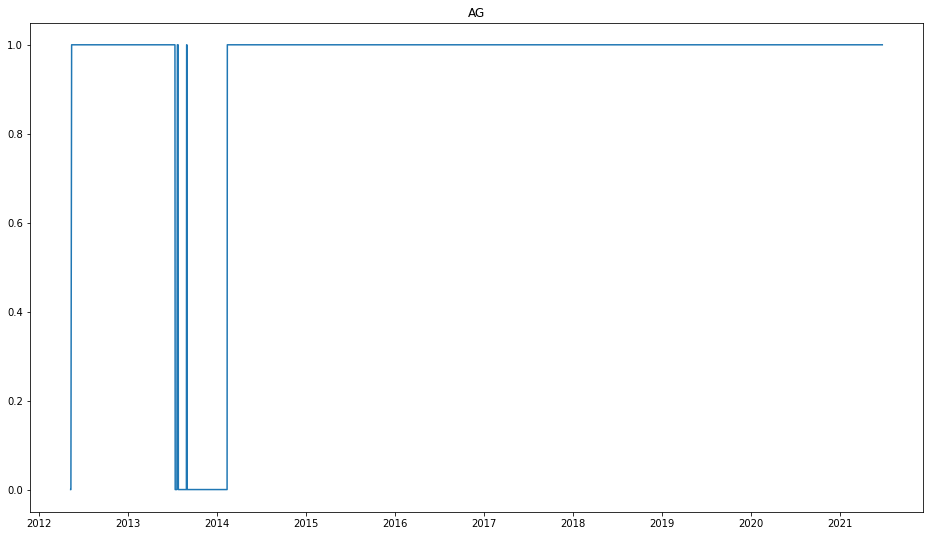

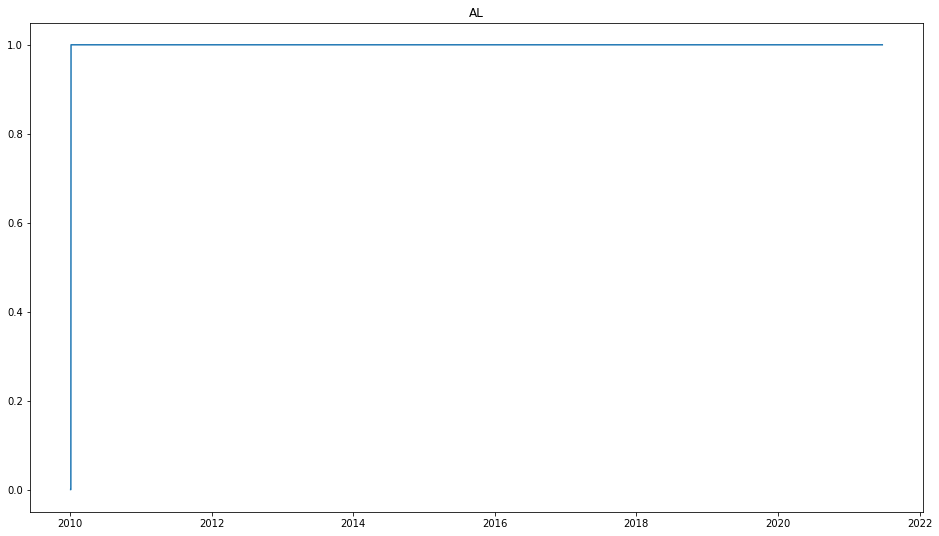

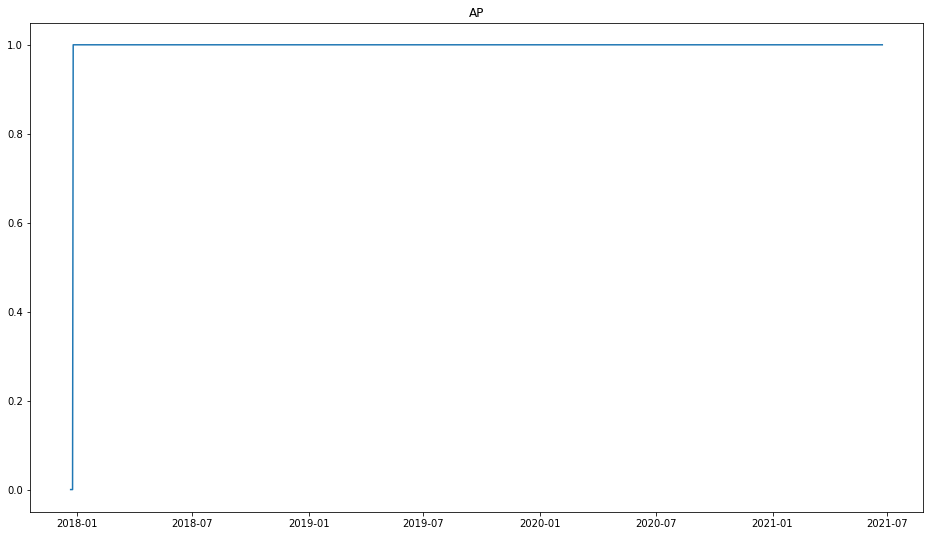

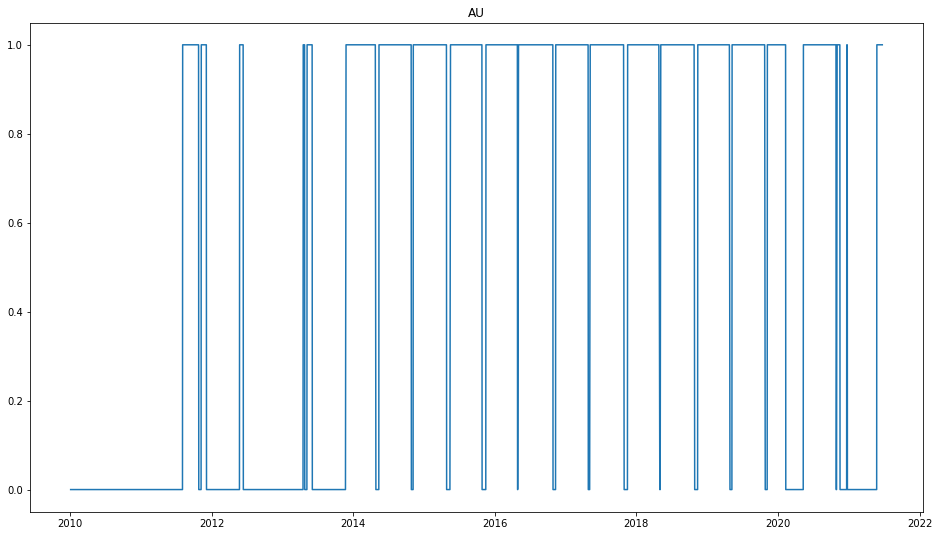

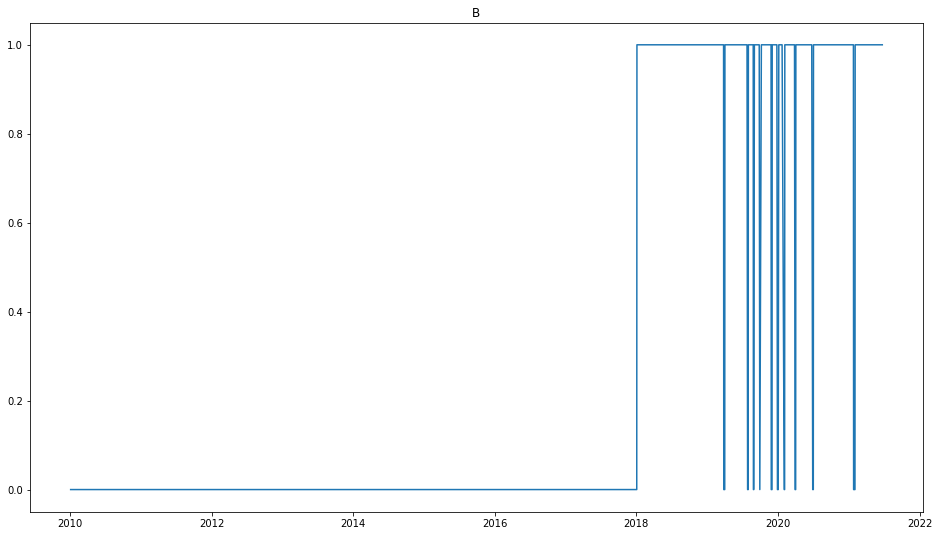

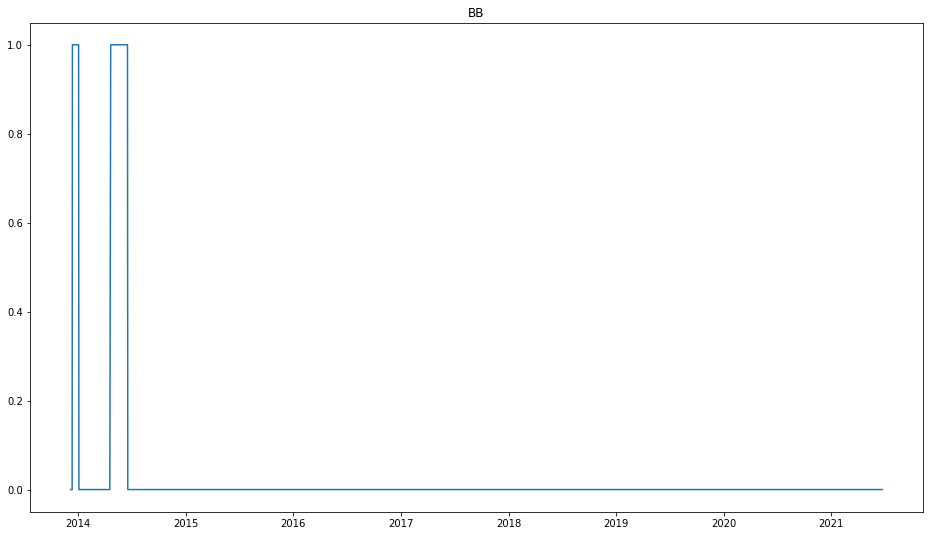

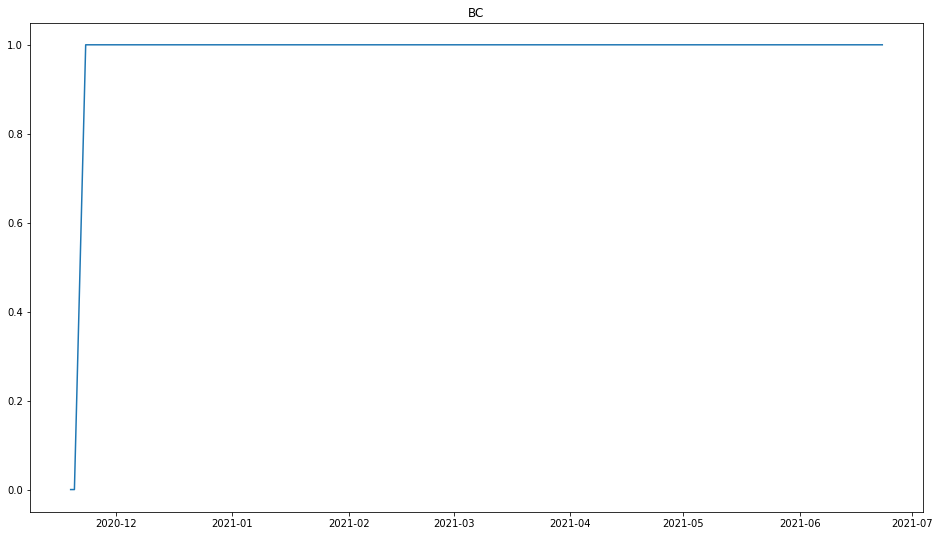

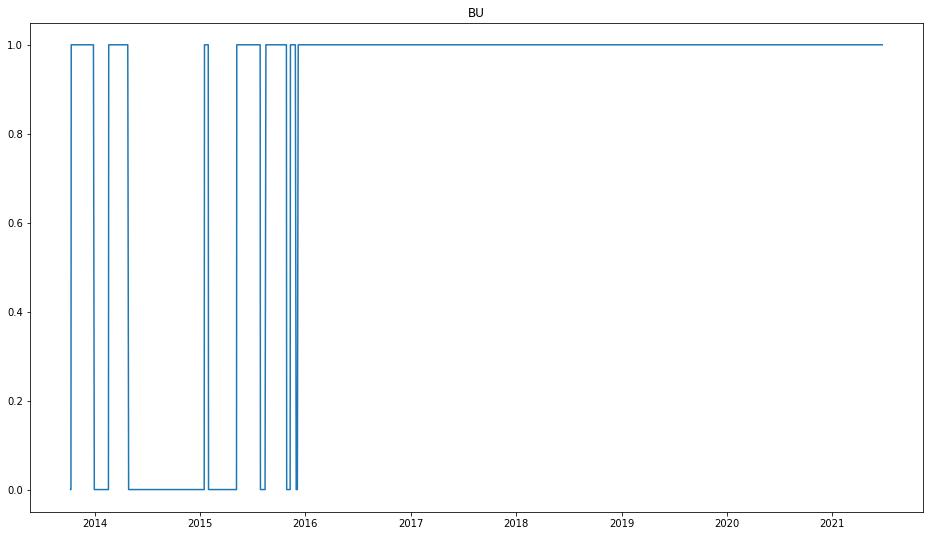

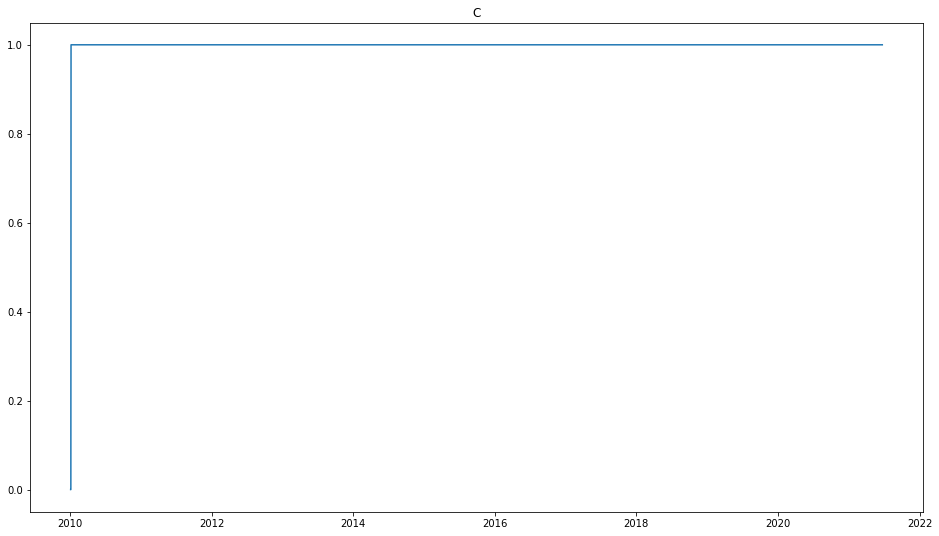

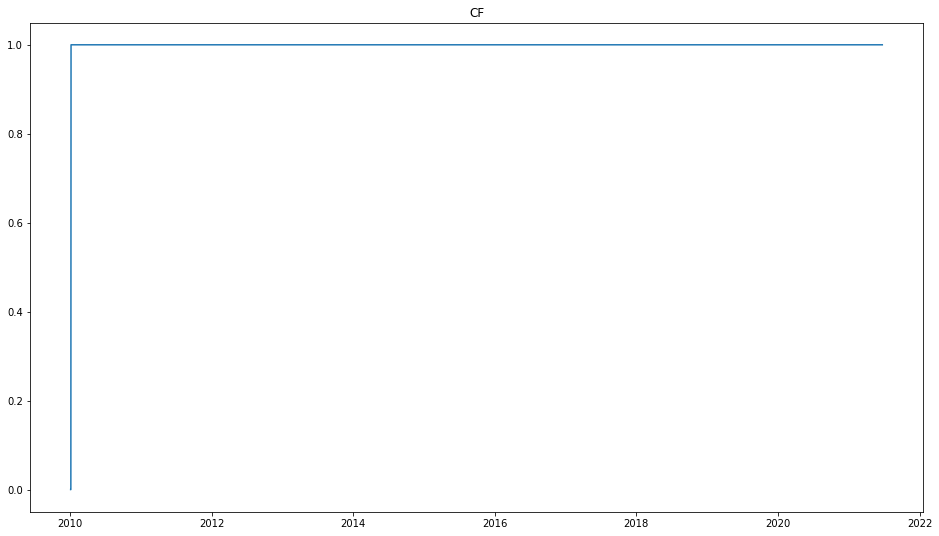

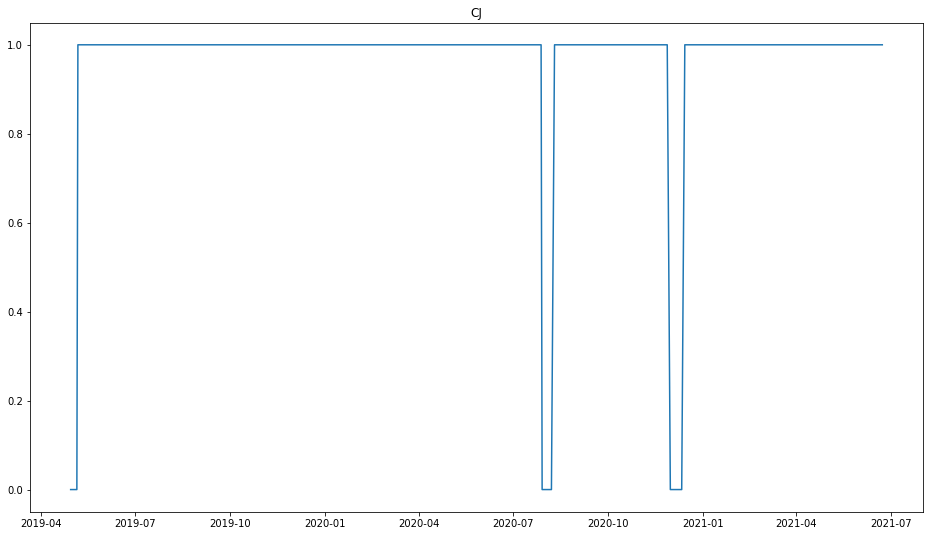

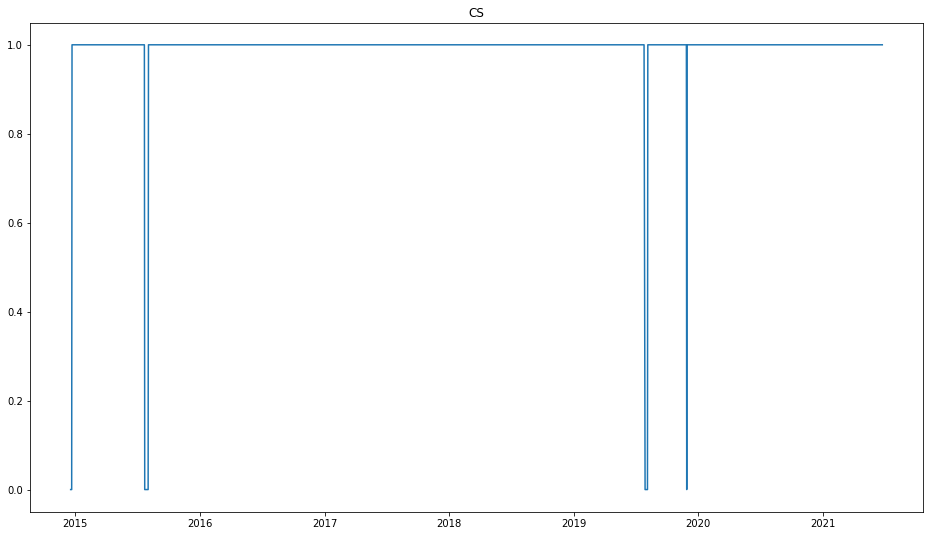

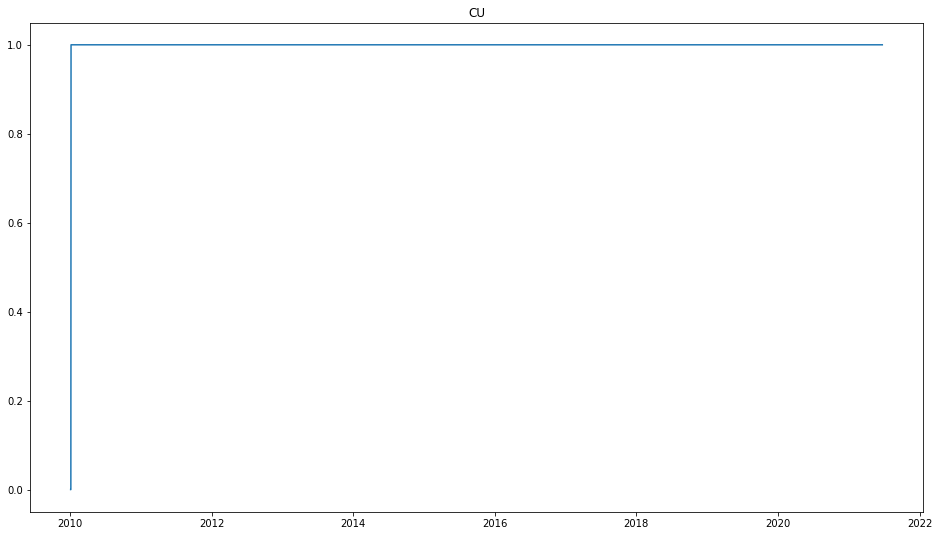

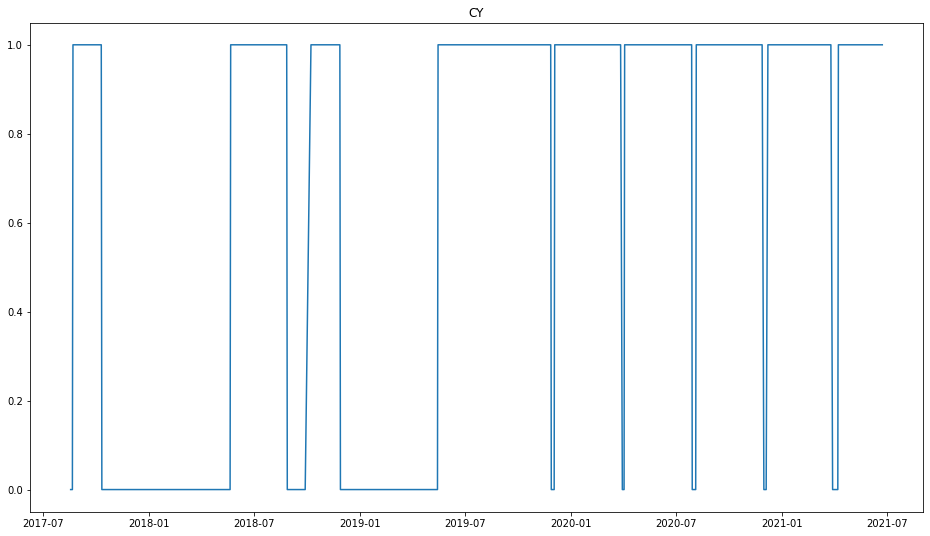

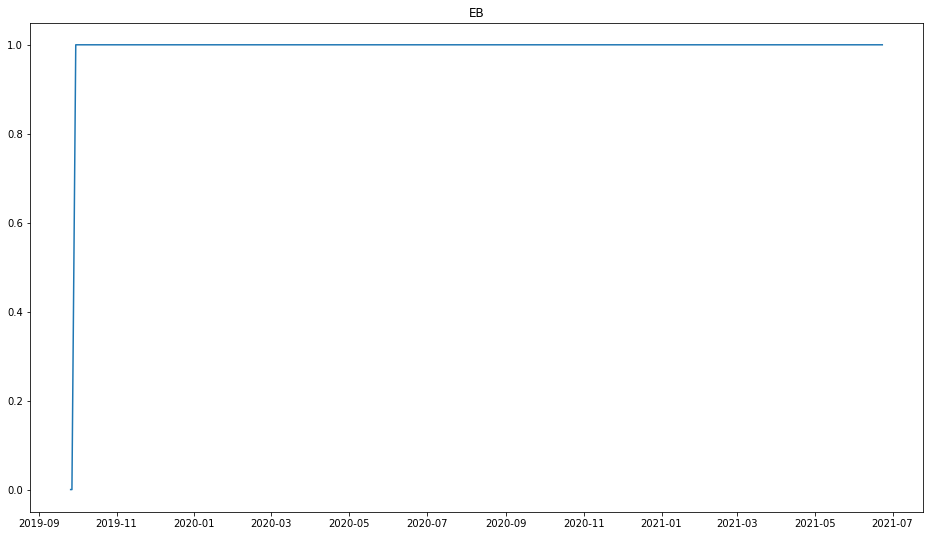

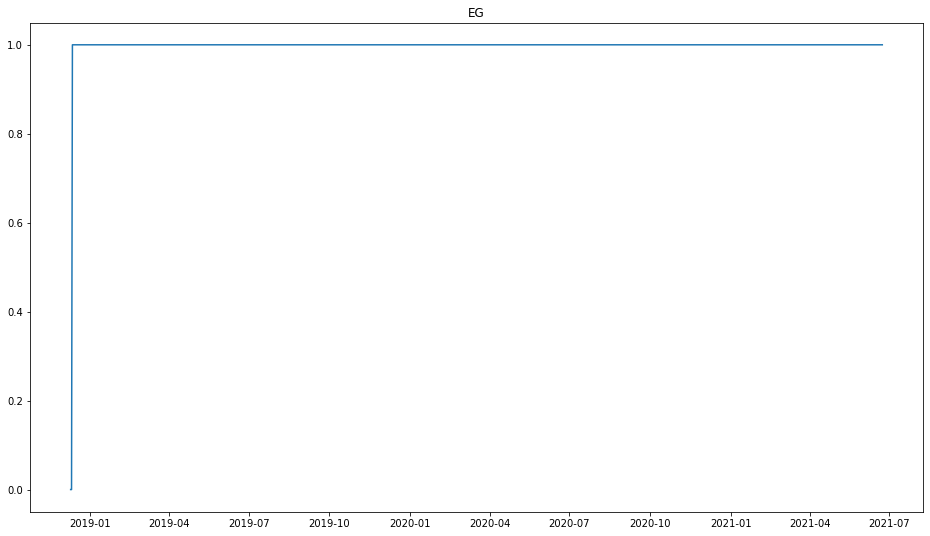

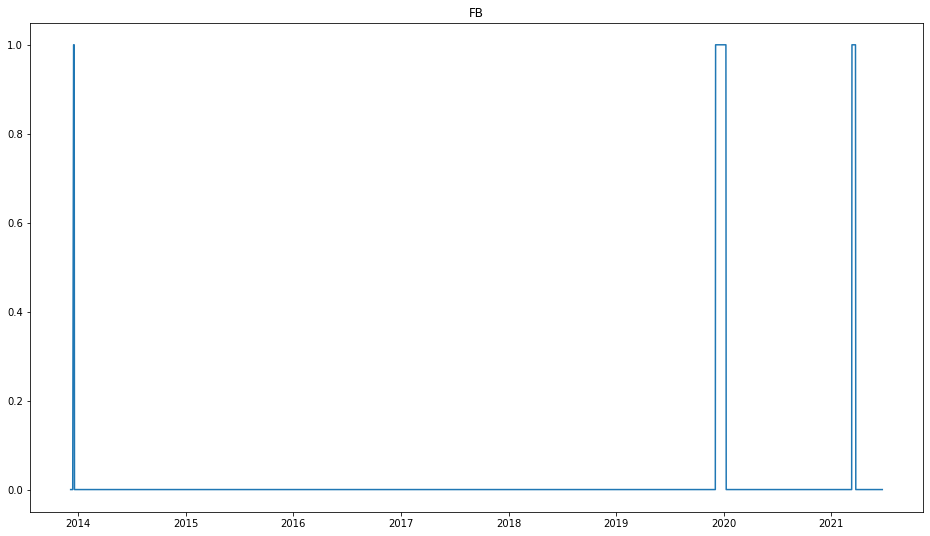

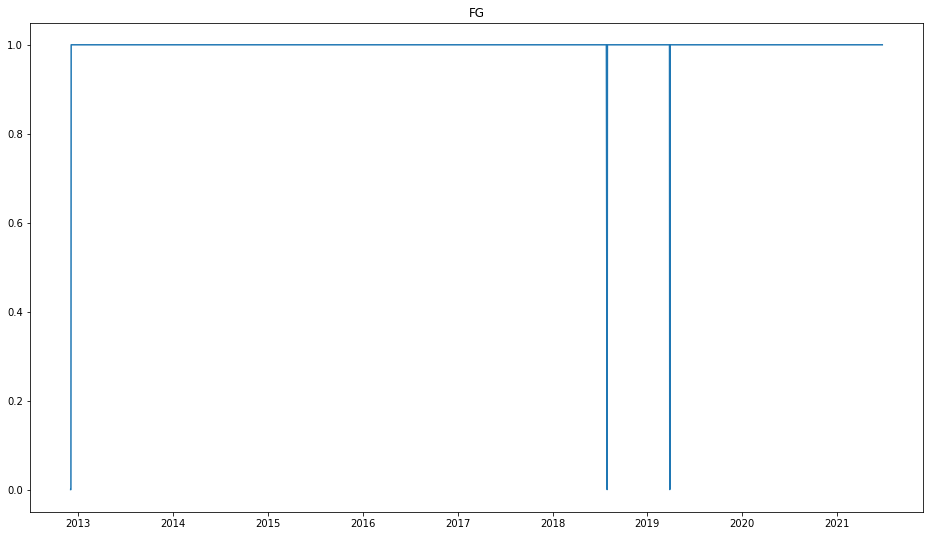

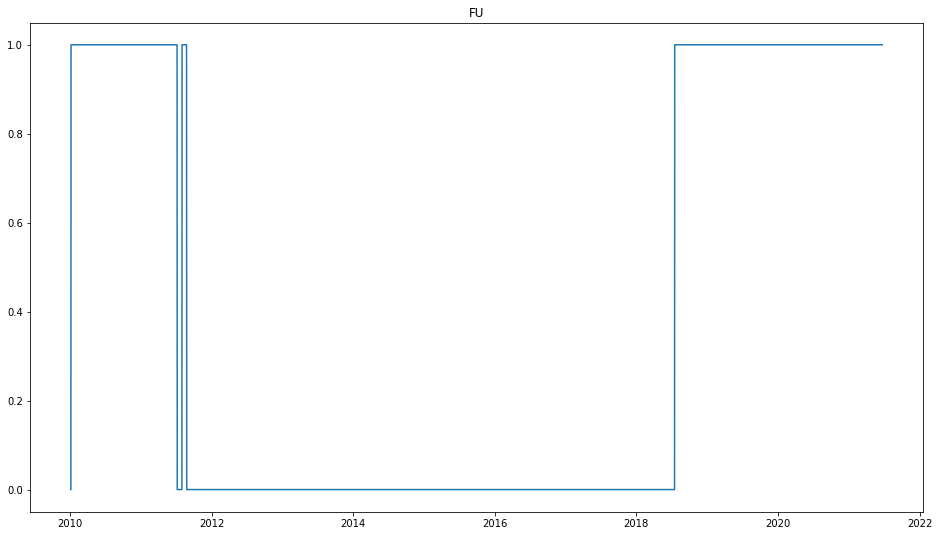

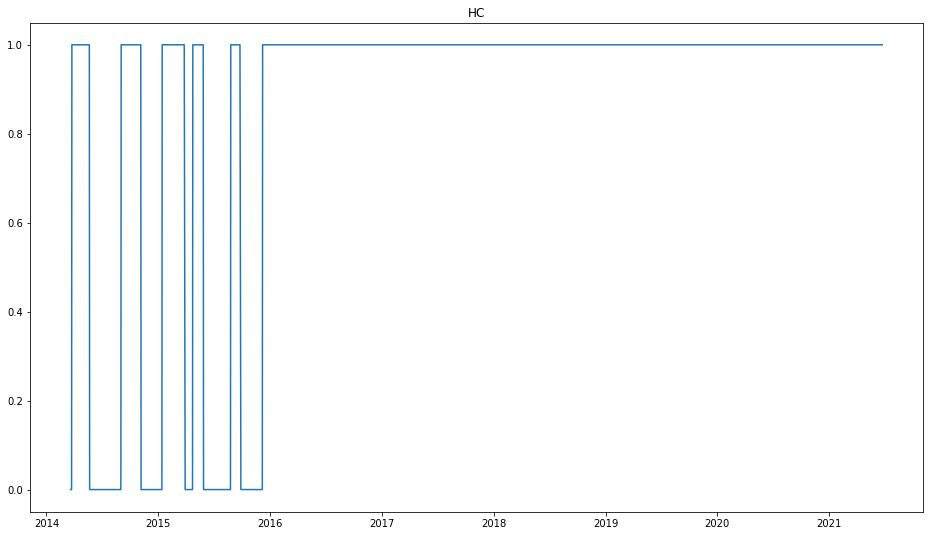

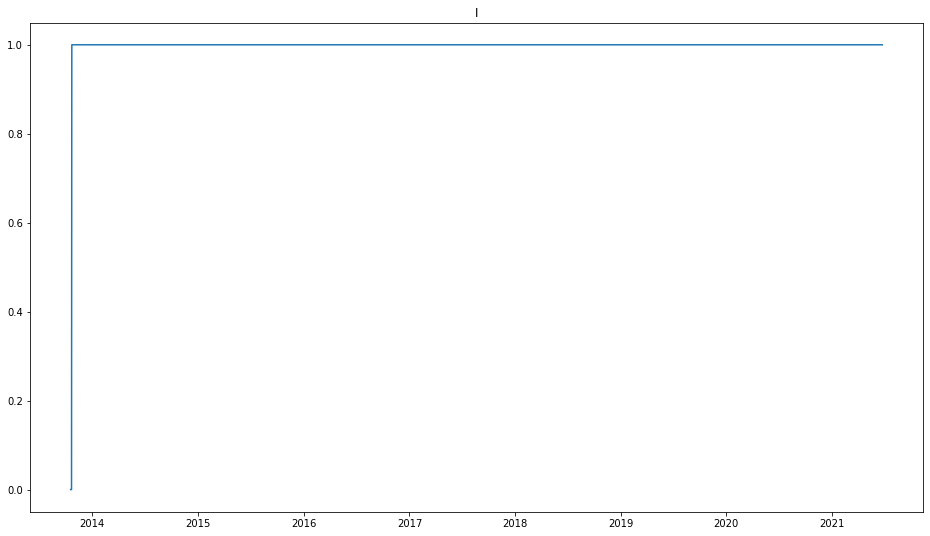

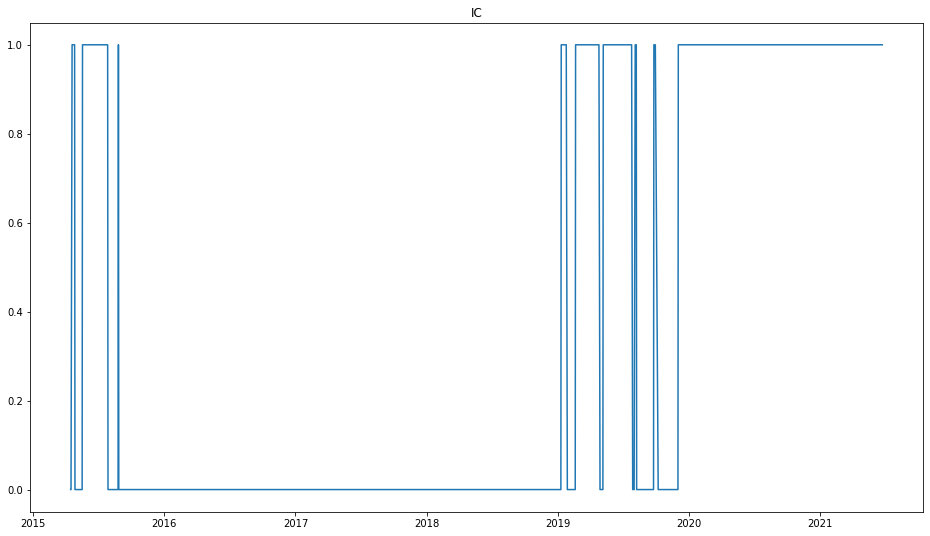

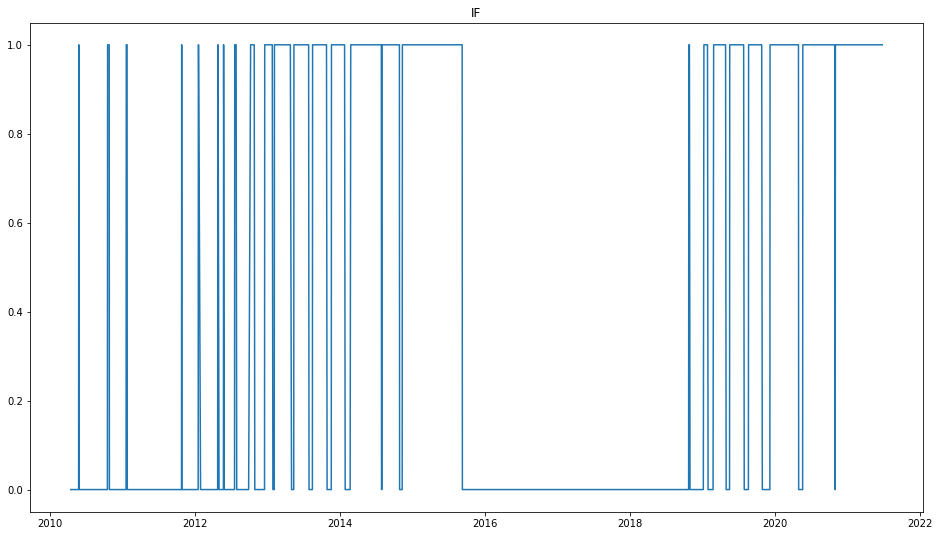

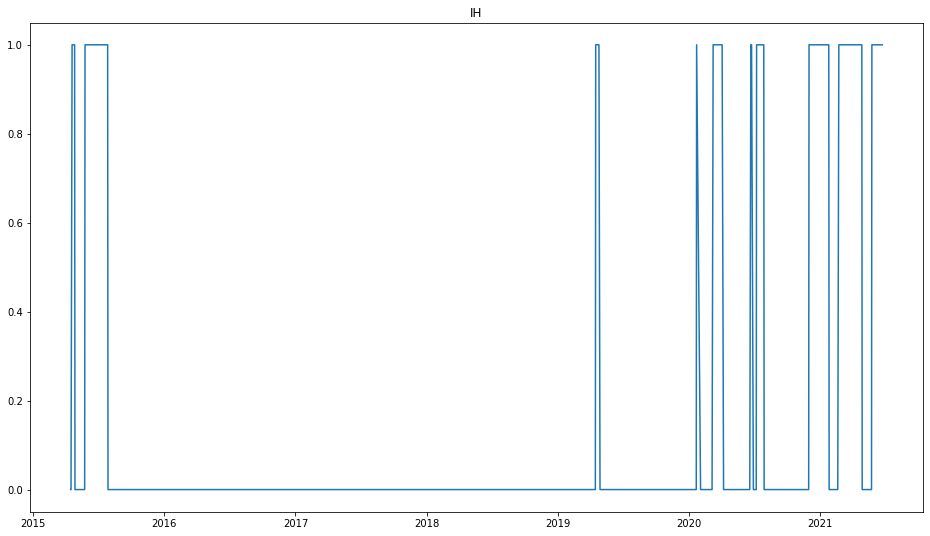

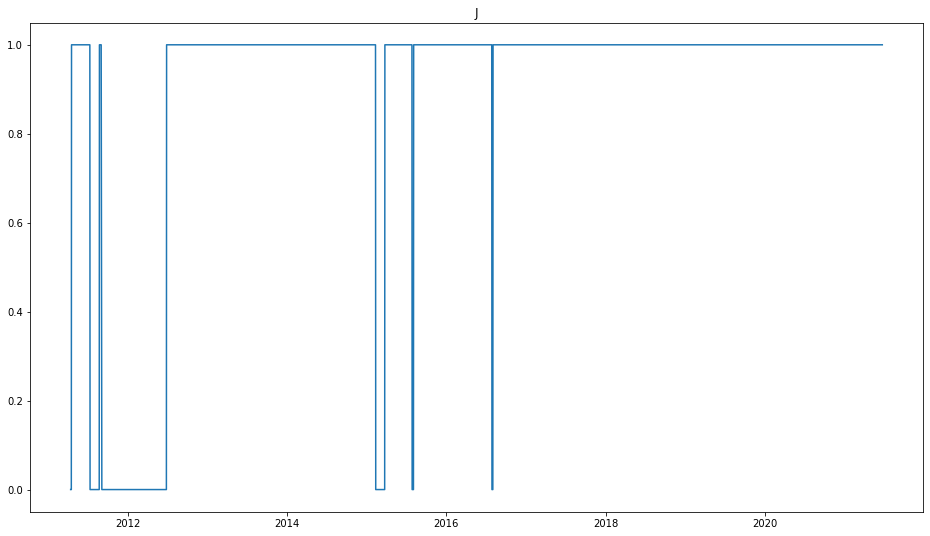

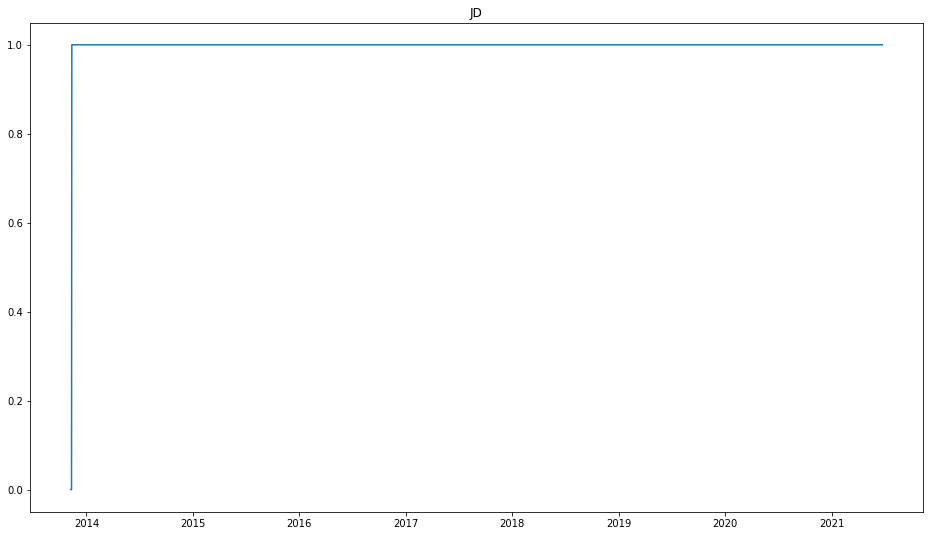

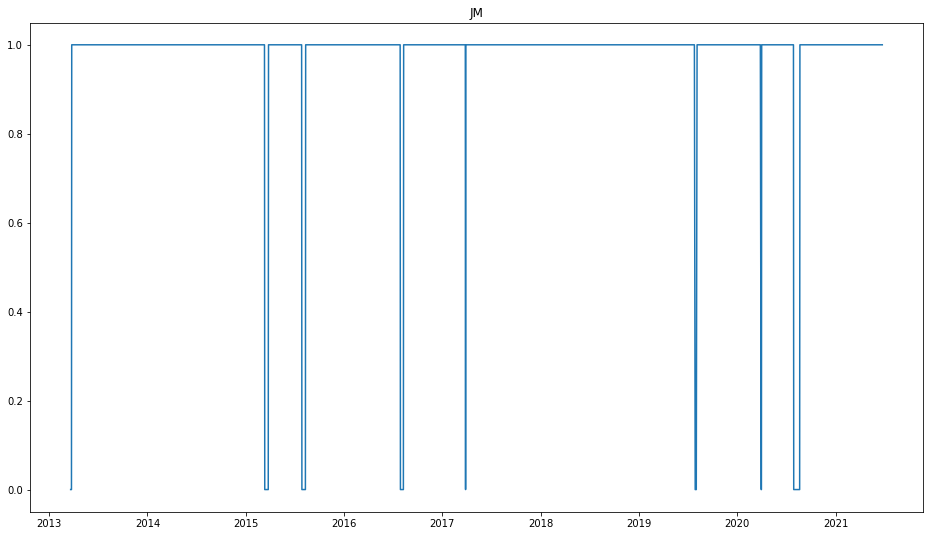

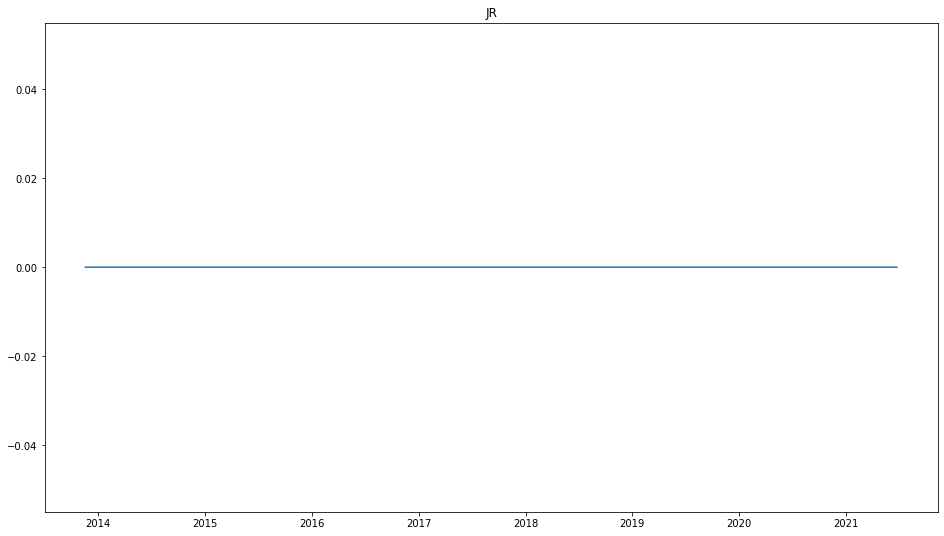

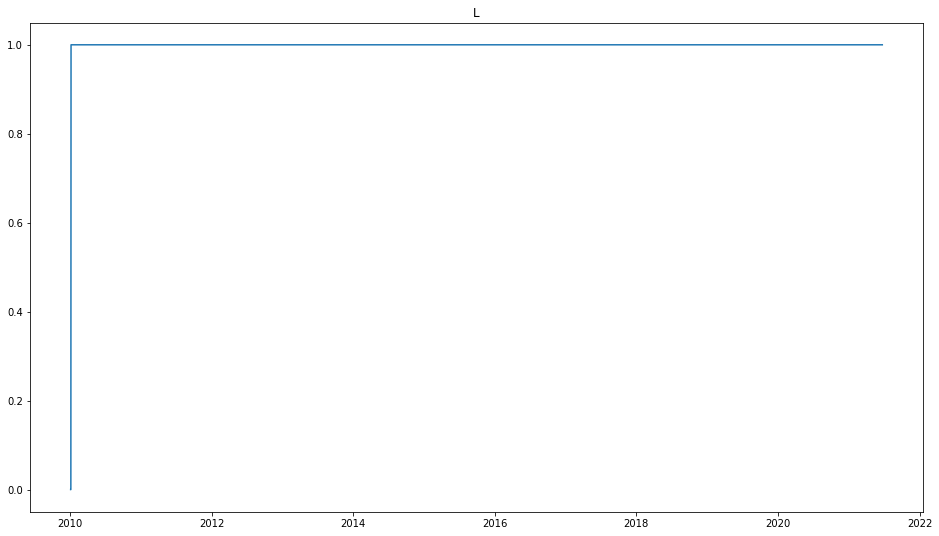

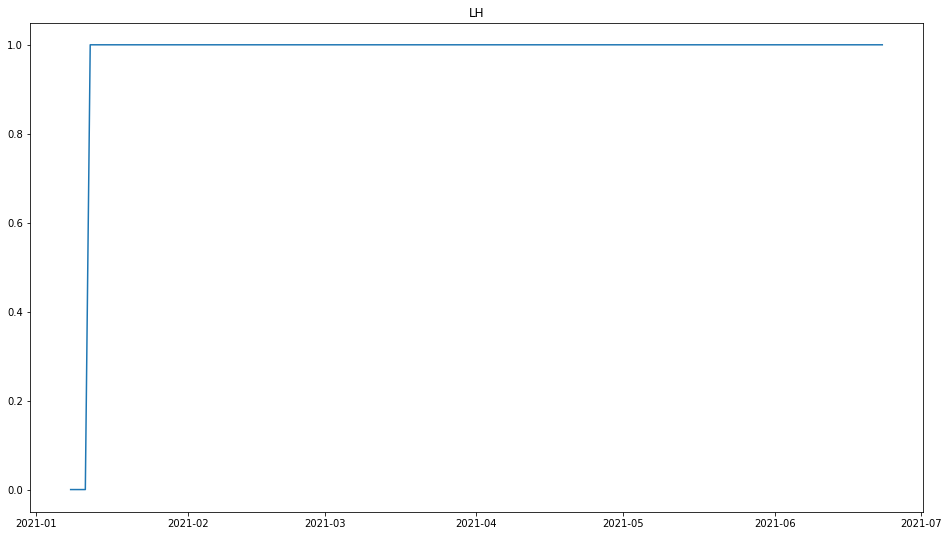

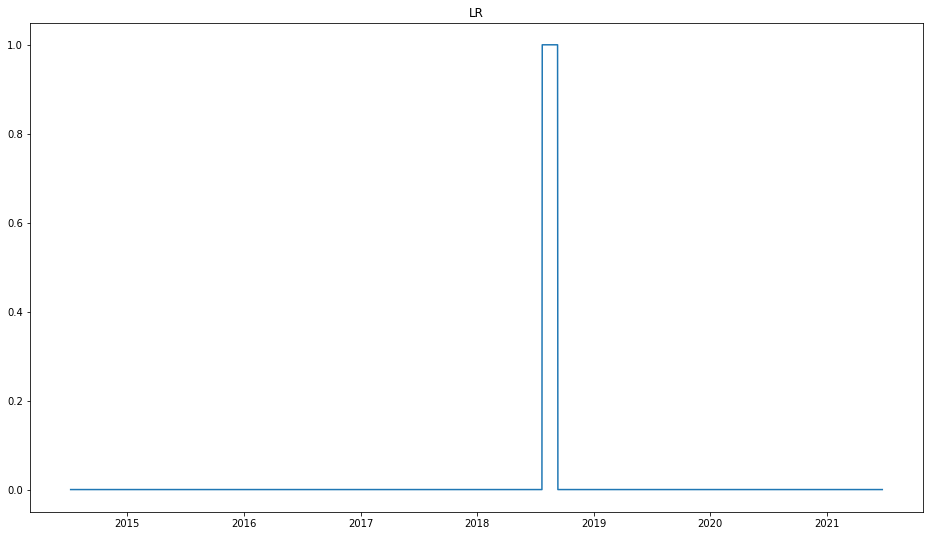

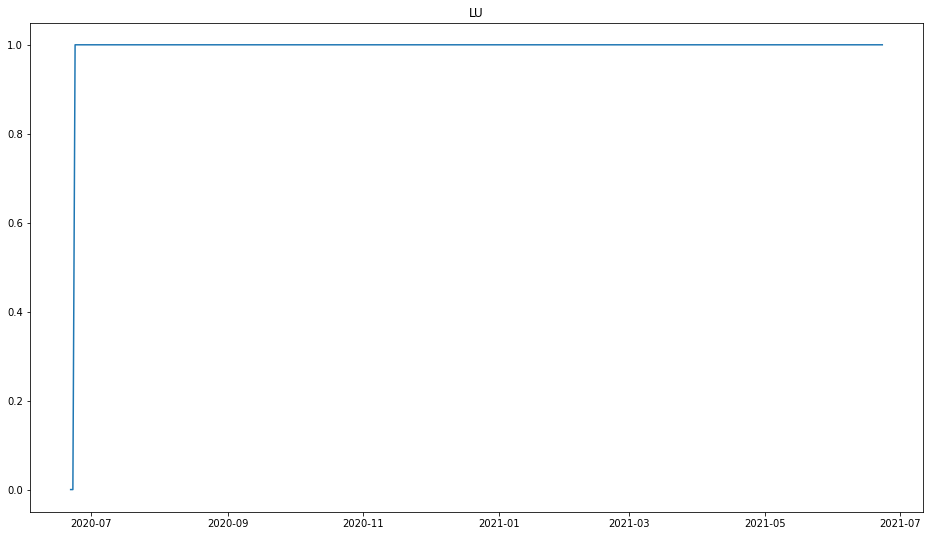

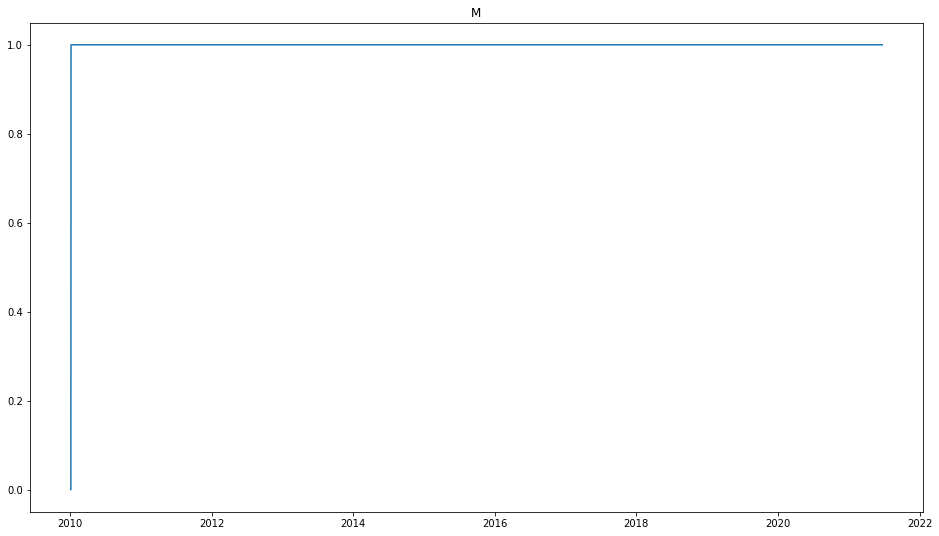

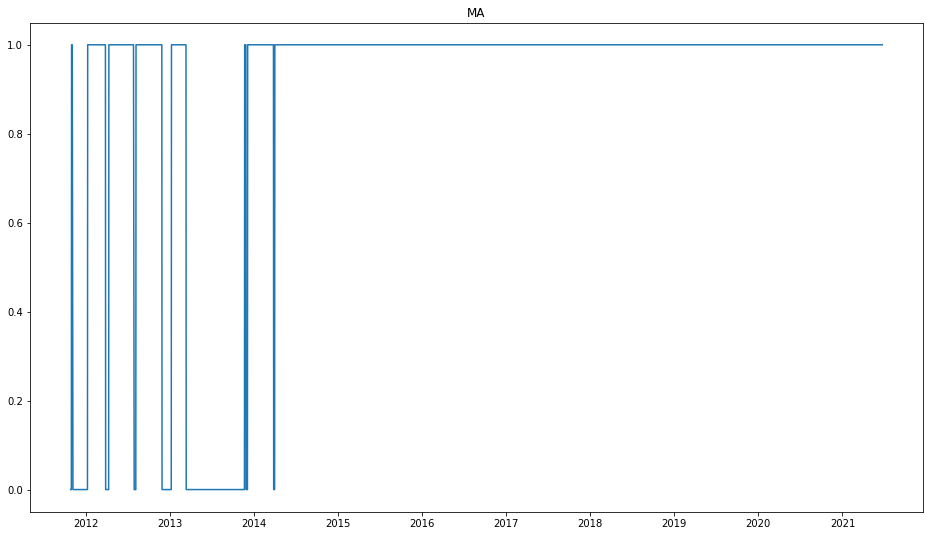

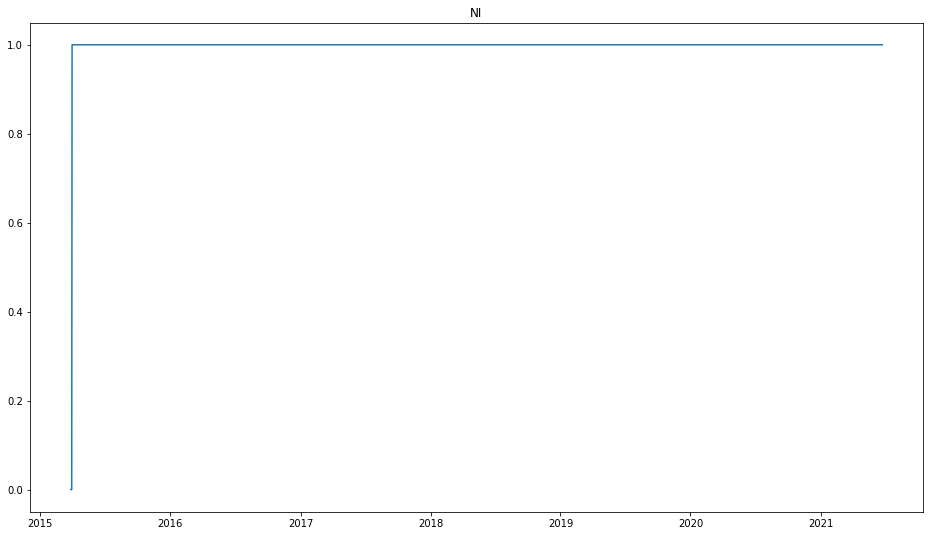

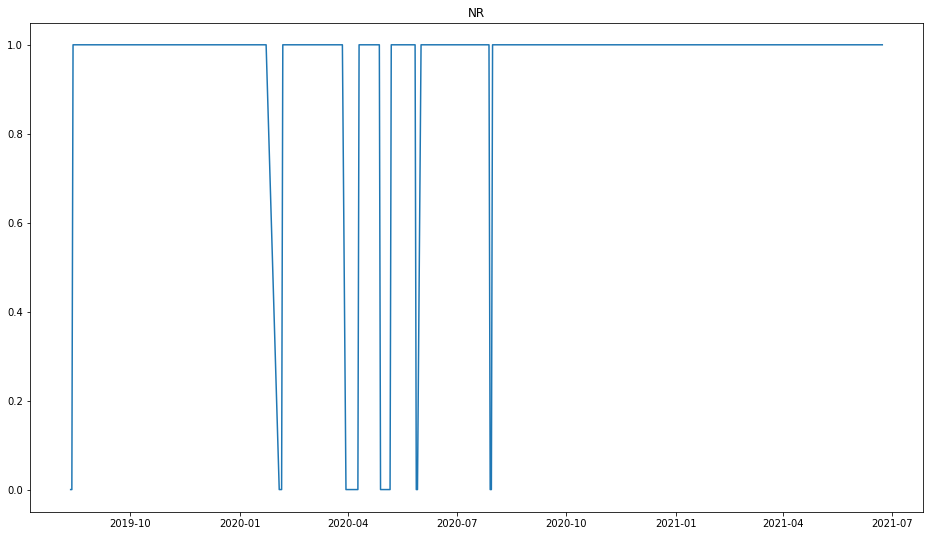

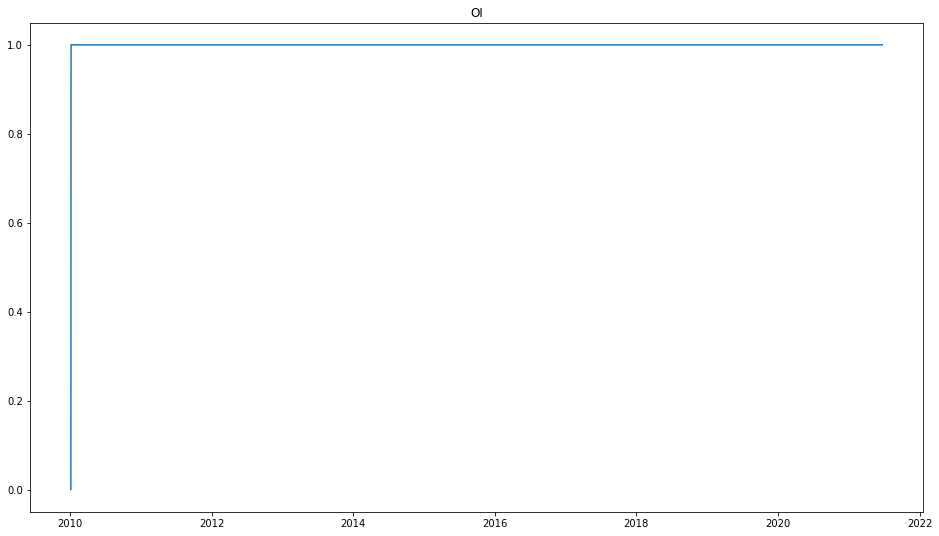

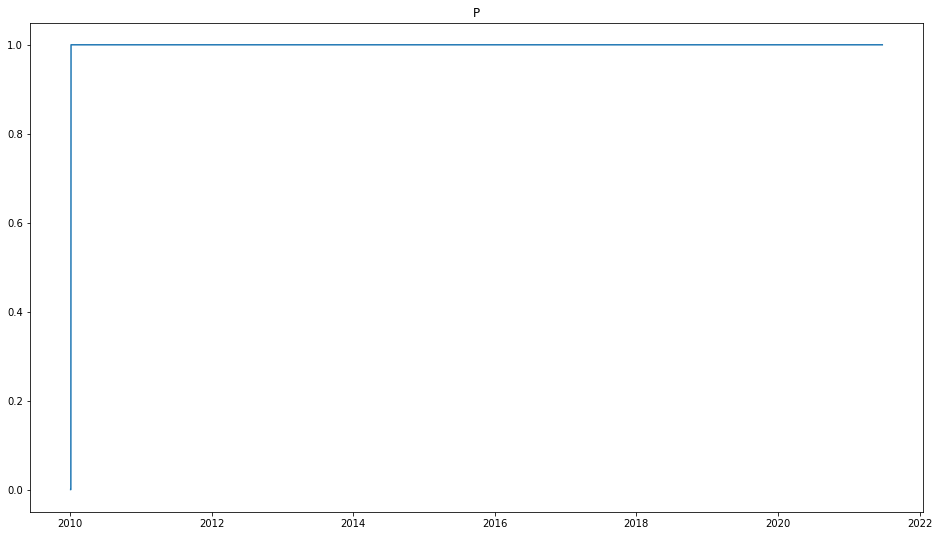

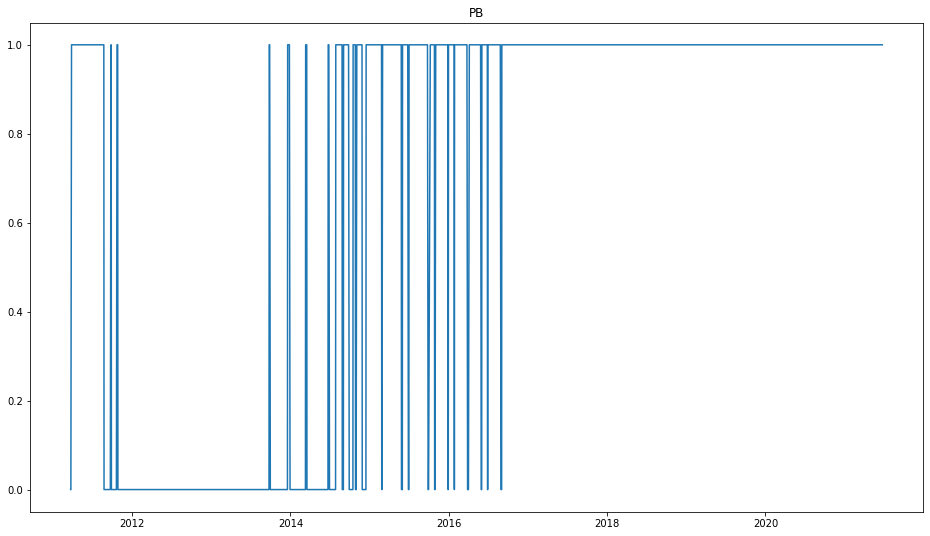

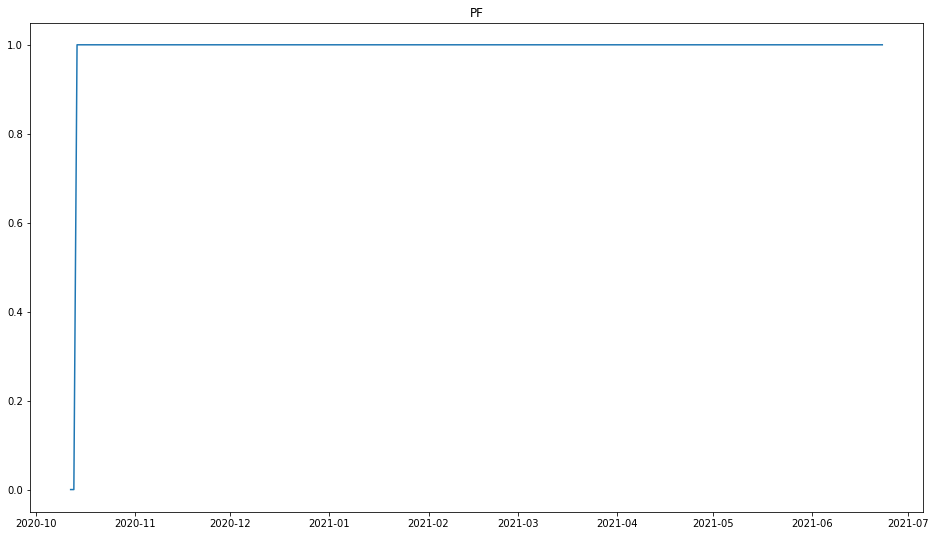

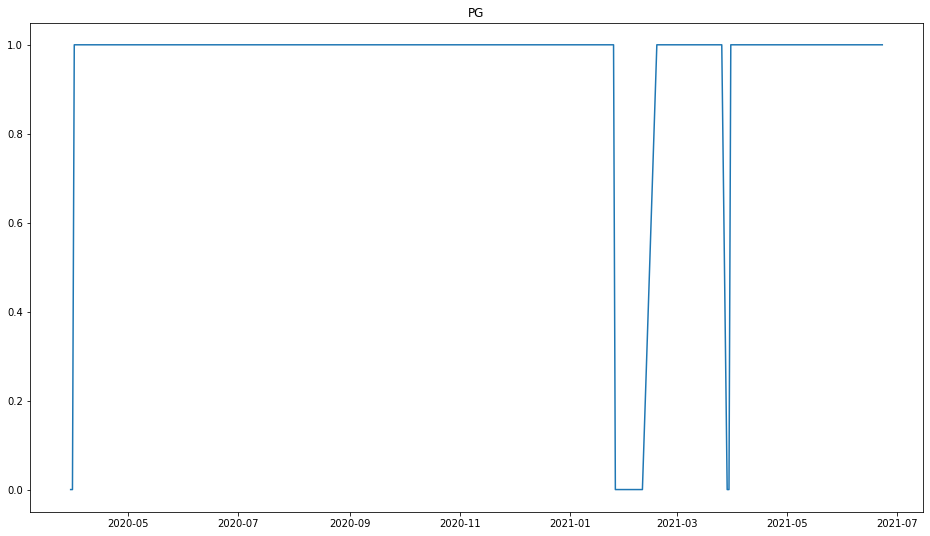

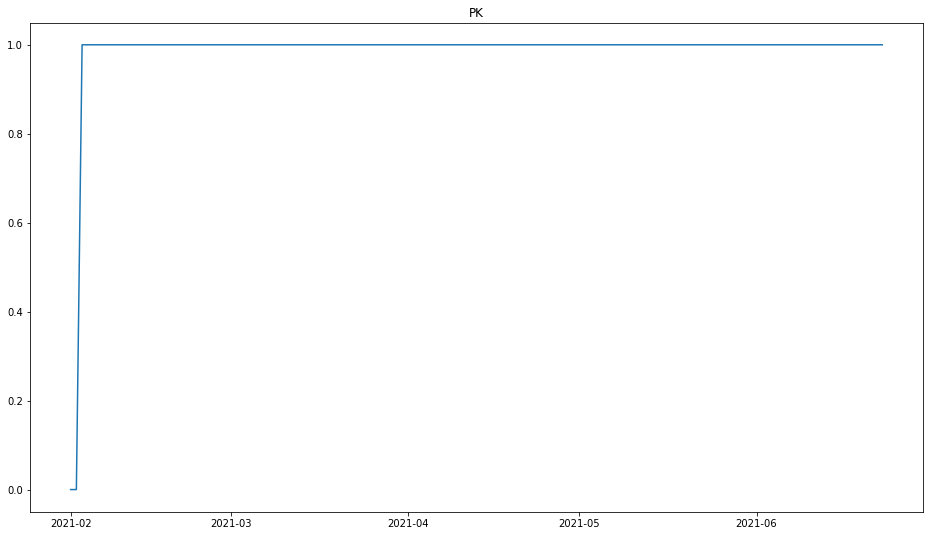

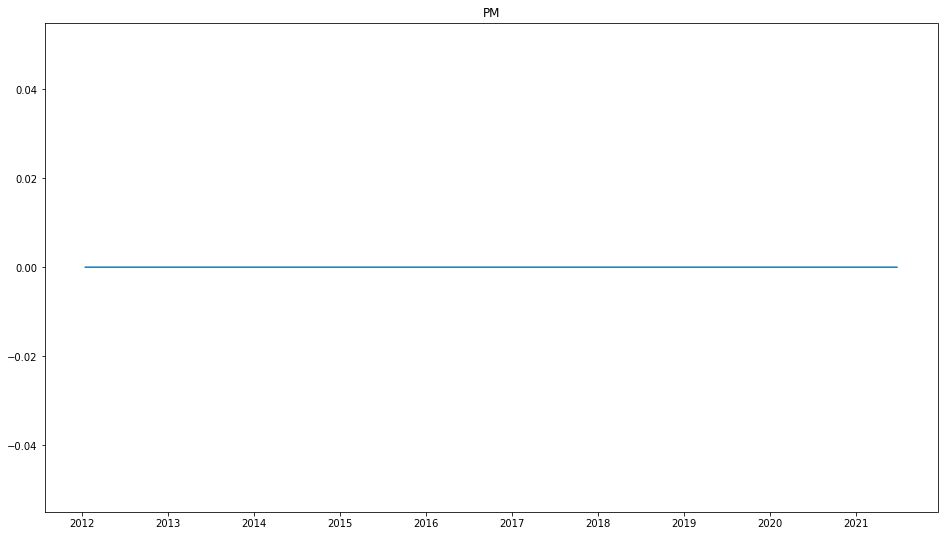

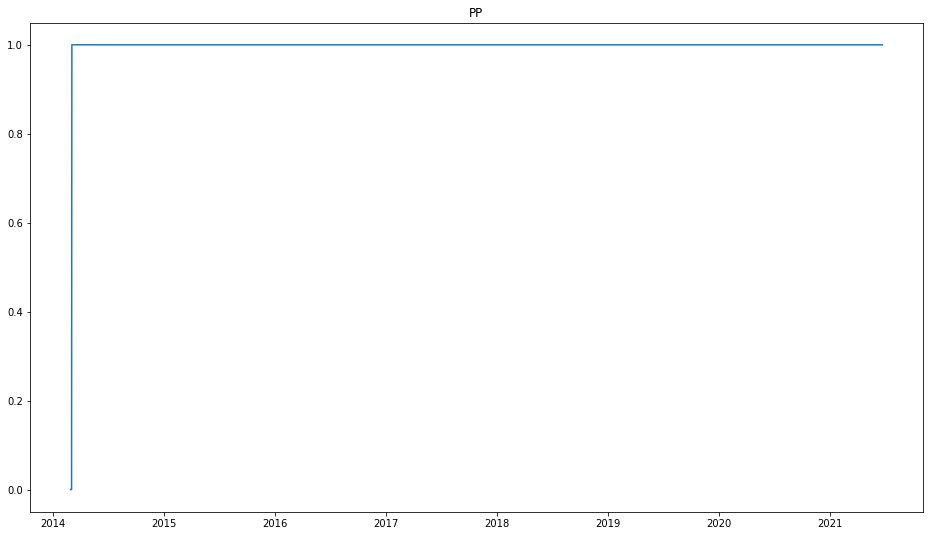

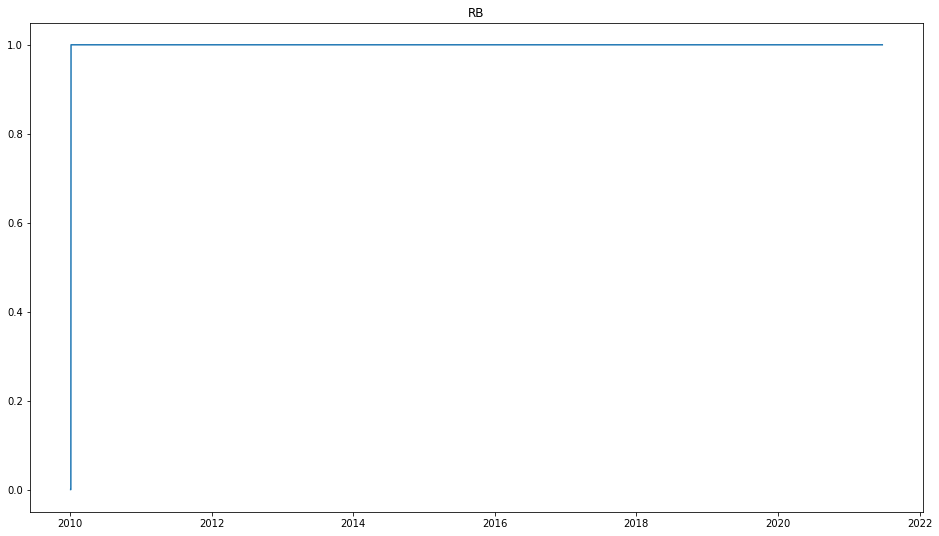

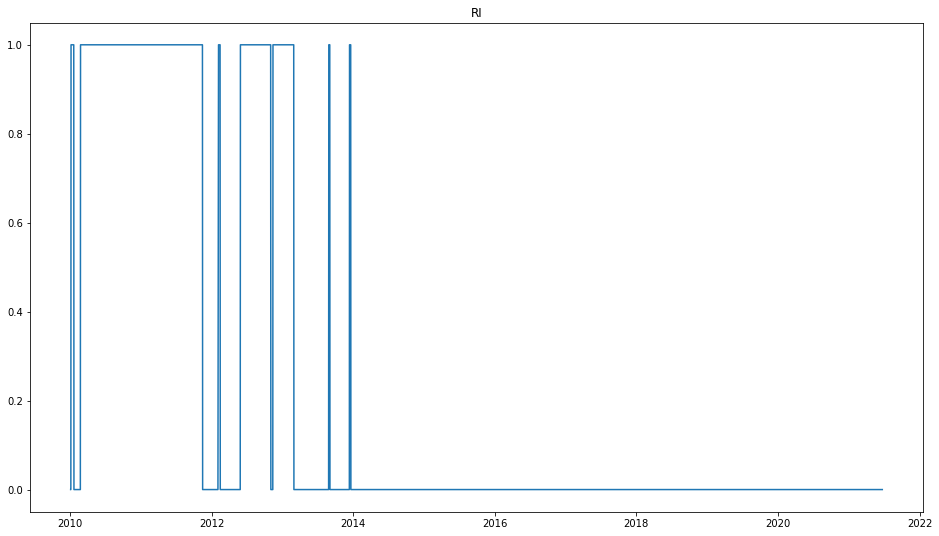

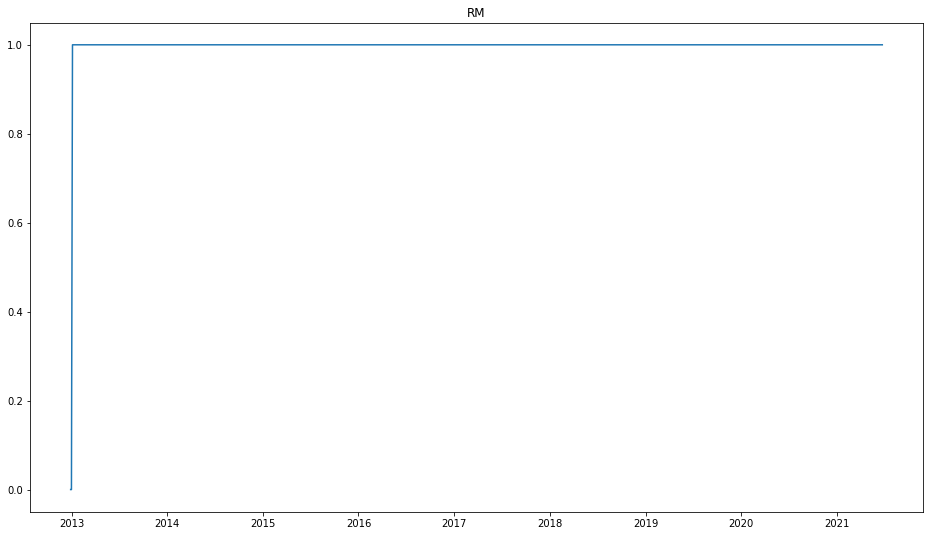

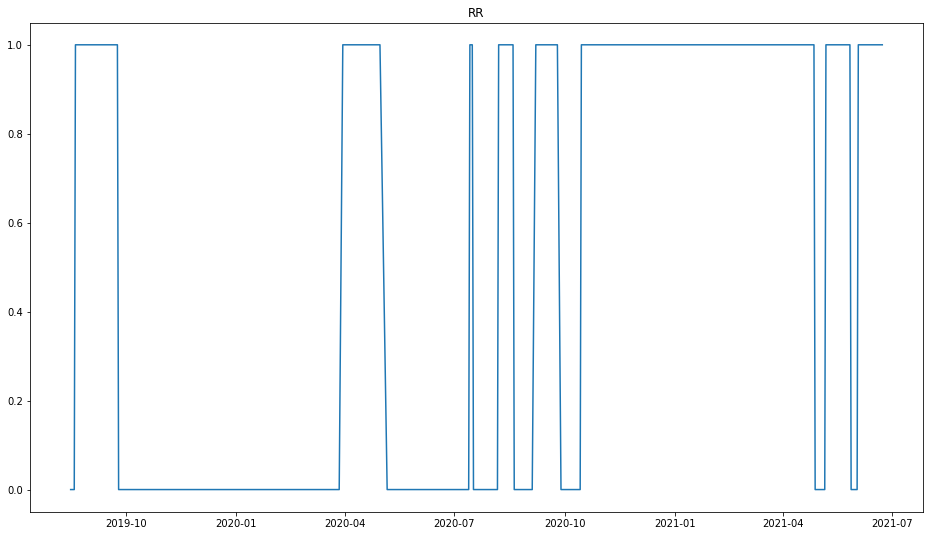

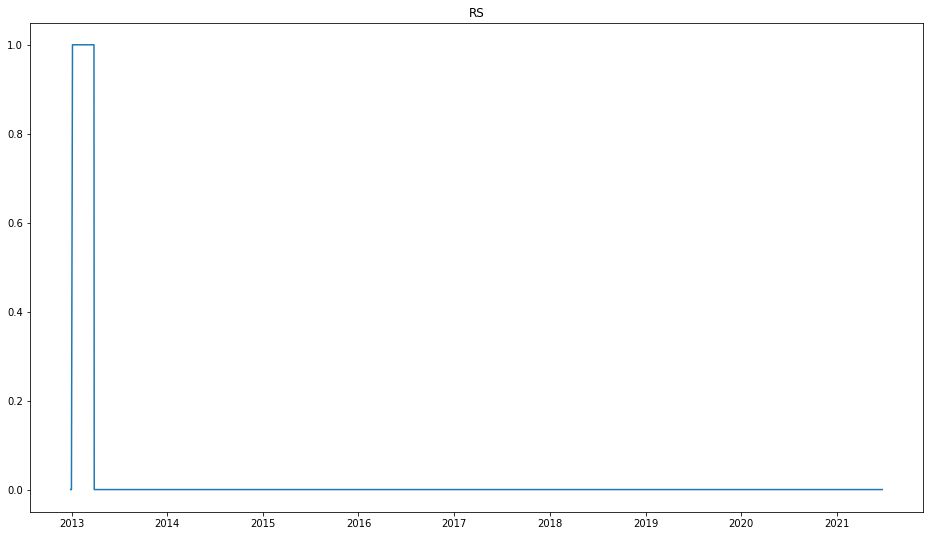

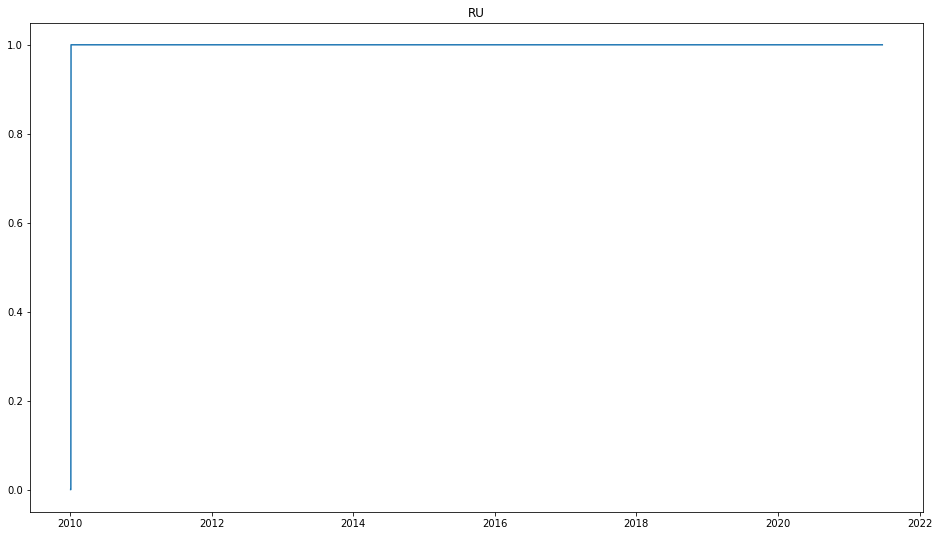

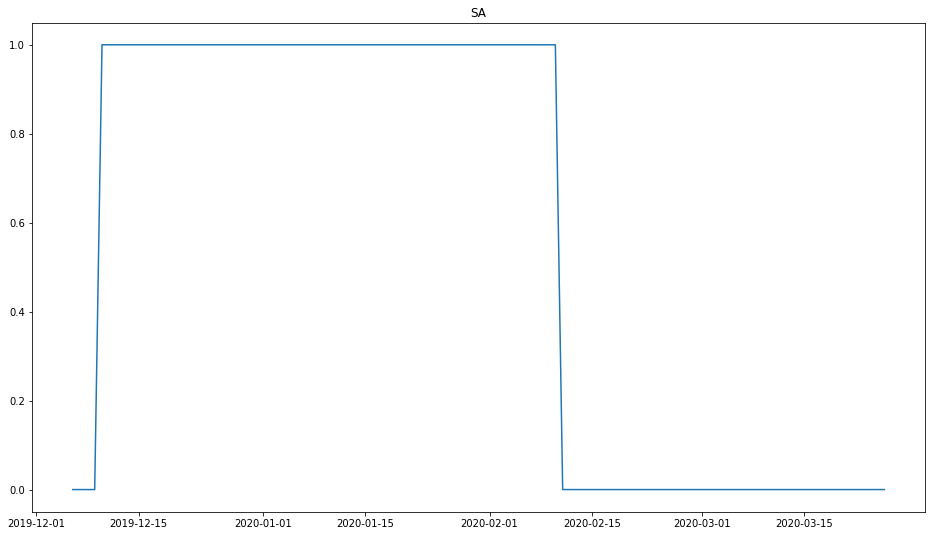

In [3]:
# problematic = ['AU', 'IC', 'IF', 'IH', 'PB', 'RR']  # 这只是部分有问题的品种 
for c, df in data.groupby('category'):
    # df = data[data.category == c]
    df['code'] = df['category'] + df['deliv_mon'].astype('str')
    df['deliv_datetime'] = df.deliv_mon.apply(to_datetime)
    df['to_deliv_date'] = df.apply(lambda x: (x['deliv_datetime'] - x['datetime']).days, axis=1)
    df['volume_value'] = df.close * df.volume
    
    df = df.set_index(['datetime', 'code']).join(is_active(df)).reset_index()
    df = df.set_index(['datetime', 'code']).join(is_inactive(df)).reset_index()
    selected = select_active_near_contract(df)
    
    has_sth_to_hold = selected.set_index('datetime').code.apply(lambda x: 0 if x is None else 1)
    fig = plt.figure(figsize=(16,9))
    plt.title(c)
    plt.plot(has_sth_to_hold)